In [1]:
# %%
# 0) Imports and code quality settings
import os
import sys
import json
import math
import textwrap
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", rc={"figure.figsize": (9, 5)})

# Statistics
from scipy import stats
from scipy.stats import chi2_contingency

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, confusion_matrix, classification_report
)

# Optional: second baseline
from sklearn.ensemble import RandomForestClassifier

# Word report (install: pip install python-docx)
try:
    from docx import Document
    from docx.shared import Inches
    DOCX_AVAILABLE = True
except Exception:
    DOCX_AVAILABLE = False

# Display options
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


In [2]:
# %%
# 1) Project setup: create the folder structure
PROJECT_ROOT = os.path.abspath("churn-capstone")
DIRS = {
    "data_raw":       os.path.join(PROJECT_ROOT, "data", "raw"),
    "data_processed": os.path.join(PROJECT_ROOT, "data", "processed"),
    "notebooks":      os.path.join(PROJECT_ROOT, "notebooks"),
    "models":         os.path.join(PROJECT_ROOT, "models"),
    "reports":        os.path.join(PROJECT_ROOT, "reports"),
    "figures":        os.path.join(PROJECT_ROOT, "figures"),
}

for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

# Path to the input file (change if needed)
DATA_PATH = "/Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone/data/raw/Telco_Cusomer_Churn.csv"  # <- your upload
if not os.path.exists(DATA_PATH):
    # Fallback: expect the file in the project's raw data folder
    fallback = os.path.join(DIRS["data_raw"], "Telco_Cusomer_Churn.csv")
    DATA_PATH = fallback


In [3]:
# %%
# 2) Loading data and initial inspection
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
display(df.head(3))
display(df.tail(3))
display(df.sample(3, random_state=42))

print("\nDtypes & memory info:")
print(df.info())


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,1024-GUALD,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.8,Yes
2715,0484-JPBRU,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No
3825,3620-EHIMZ,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.7,No



Dtypes & memory info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

In [4]:
# %%
# Helpers: reports for missing values / duplicates / dtypes
def missing_report(data: pd.DataFrame) -> pd.DataFrame:
    """Return a table with counts and percentage of missing values per column."""
    m = data.isna().sum().sort_values(ascending=False)
    pct = (m / len(data) * 100).round(2)
    return pd.DataFrame({"missing": m, "missing_%": pct})

def duplicates_report(data: pd.DataFrame, subset=None):
    """Return the number of duplicate rows (optionally by a subset of columns)."""
    if subset is None:
        return data.duplicated().sum()
    return data.duplicated(subset=subset).sum()

miss_tbl = missing_report(df)
print("Missing values by column:")
display(miss_tbl.head(20))

if "customerID" in df.columns:
    print("Number of full-row duplicates:", duplicates_report(df))
    print("Number of potential duplicates by customerID:", duplicates_report(df, subset=["customerID"]))


Missing values by column:


,missing,missing_%
customerID,0,0.0
DeviceProtection,0,0.0
TotalCharges,0,0.0
MonthlyCharges,0,0.0
PaymentMethod,0,0.0
PaperlessBilling,0,0.0
Contract,0,0.0
StreamingMovies,0,0.0
StreamingTV,0,0.0
TechSupport,0,0.0


Number of full-row duplicates: 0
Number of potential duplicates by customerID: 0


In [5]:
# %%
# 3) Minimal type/value cleaning for the classic Telco dataset (safe transforms)
df_clean = df.copy()

# Normalize string values
for c in df_clean.select_dtypes(include="object").columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# Cast TotalCharges to numeric (often a string with blanks in Telco)
if "TotalCharges" in df_clean.columns:
    df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

# SeniorCitizen: 0/1 -> 'No'/'Yes' (if present)
if "SeniorCitizen" in df_clean.columns and np.issubdtype(df_clean["SeniorCitizen"].dtype, np.number):
    df_clean["SeniorCitizen"] = df_clean["SeniorCitizen"].map({0: "No", 1: "Yes"}).astype("category")

# Drop exact duplicate rows
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f"Duplicates removed: {before - after}")

# Impute missing values with simple strategies (proper imputation will be in the ML pipeline; this is just for EDA)
for c in df_clean.select_dtypes(include=np.number).columns:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in df_clean.select_dtypes(include="object").columns:
    df_clean[c] = df_clean[c].fillna("Unknown")

# Cast categoricals to 'category' dtype (except the target)
for c in df_clean.select_dtypes(include="object").columns:
    if c.lower() != "churn":
        df_clean[c] = df_clean[c].astype("category")

display(df_clean.head())


Duplicates removed: 0


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
# === FIX: target, leakage & IDs (unified and consistent) ===
import pandas as pd
import numpy as np

# Use a single base dataframe for X and y
BASE = df_clean if 'df_clean' in globals() and isinstance(df_clean, pd.DataFrame) else df
assert isinstance(BASE, pd.DataFrame), "Neither df_clean nor df with data was found"

# Find the target column 'Churn' (case-insensitive, trim spaces)
TARGET = None
for c in BASE.columns:
    if c.strip().lower() == "churn":
        TARGET = c
        break
assert TARGET is not None, "Could not unambiguously find the target column 'Churn'"

# Exclude leakage and identifier columns
drop_cols = [c for c in ["_y", "customerID"] if c in BASE.columns]
if drop_cols:
    print("Excluding from features:", drop_cols)


Excluding from features: ['customerID']


In [41]:
# %%
# 5) Detailed EDA (distributions & relationships)
# 5.1 Numeric and categorical features
num_cols = [c for c in df_clean.select_dtypes(include=np.number).columns if c != TARGET]
cat_cols = [c for c in df_clean.select_dtypes(include=["object","category","bool"]).columns if c != TARGET]

print("Numeric features:", num_cols)
print("Categorical features:", cat_cols)


Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


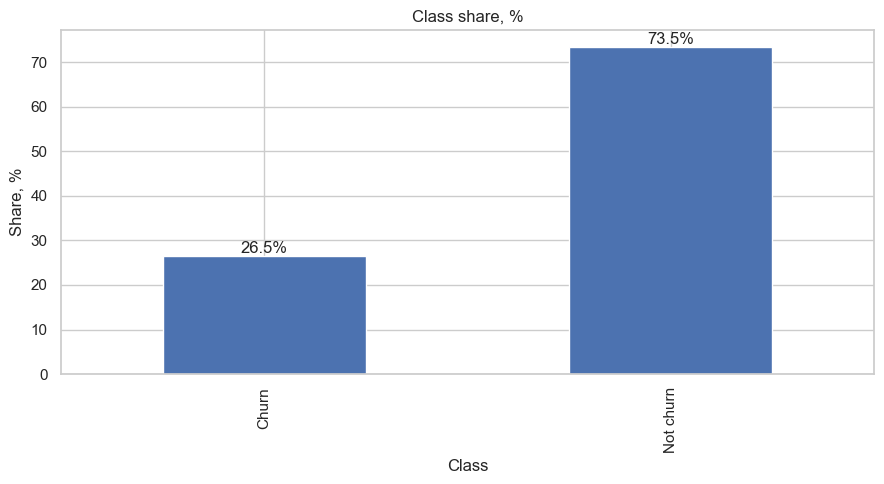

In [43]:
# %%
# 5.2 Plot: class balance
ax = (y.replace({0: "Not churn", 1: "Churn"})
        .value_counts(normalize=True)
        .mul(100)
        .sort_index()
        .plot(kind="bar"))
ax.set_title("Class share, %")
ax.set_xlabel("Class")
ax.set_ylabel("Share, %")
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width()/2, p.get_height()),
                ha="center", va="bottom")
plt.tight_layout()
plt.savefig(os.path.join(DIRS["figures"], "class_balance.png"), dpi=150)
plt.show()


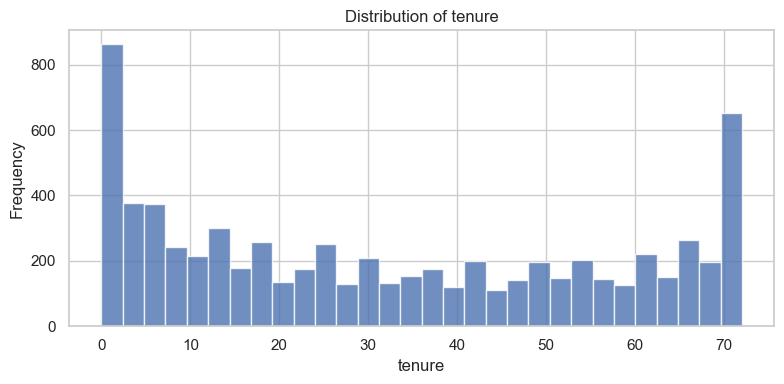

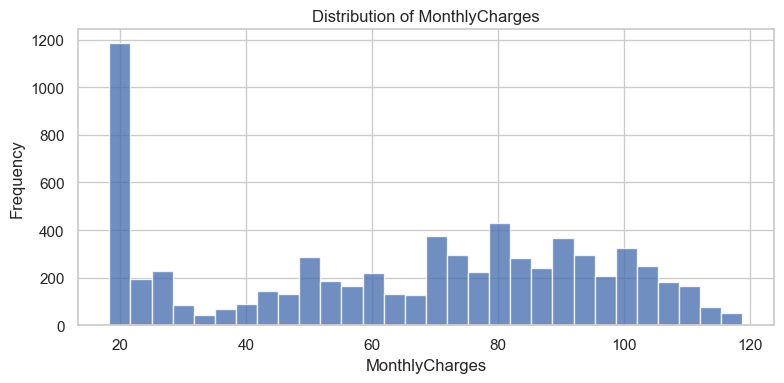

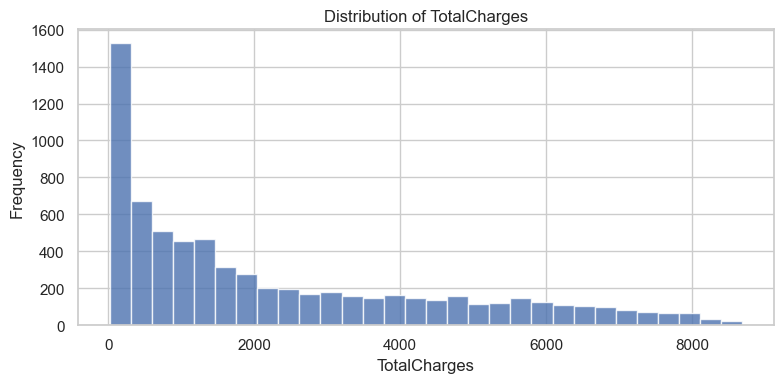

In [45]:
# %%
# 5.3 Distributions of numeric features
for c in num_cols:
    fig, ax = plt.subplots(figsize=(8, 4))
    df_clean[c].plot(kind="hist", bins=30, ax=ax, alpha=0.8)
    ax.set_title(f"Distribution of {c}")
    ax.set_xlabel(c)
    ax.set_ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(DIRS["figures"], f"num_dist__{c}.png"), dpi=150)
    plt.show()


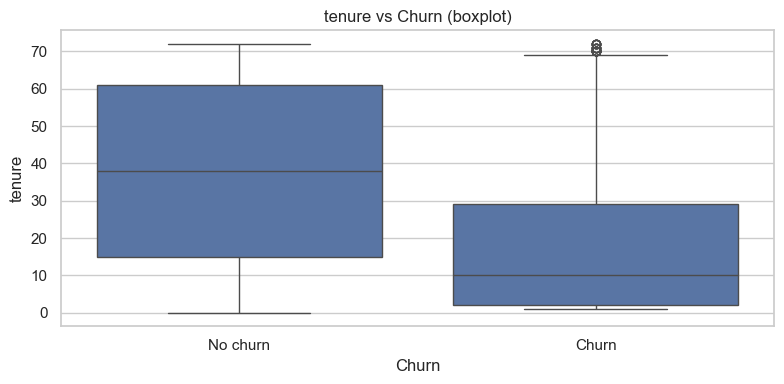

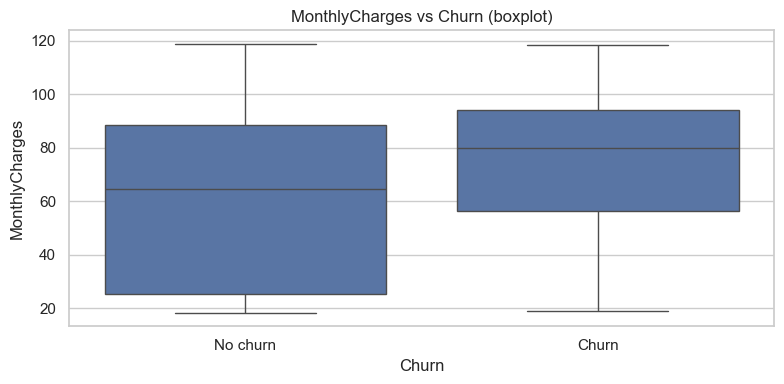

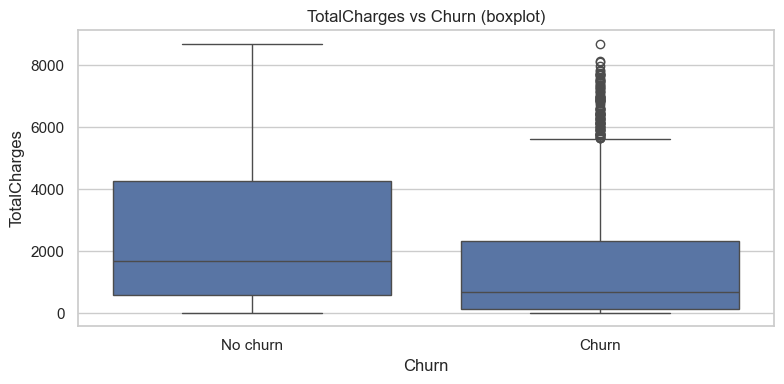

In [46]:
# %%
# 5.4 Numeric features vs churn (boxplots)
for c in num_cols:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=y.map({0: "No churn", 1: "Churn"}), y=df_clean[c], ax=ax)
    ax.set_title(f"{c} vs Churn (boxplot)")
    ax.set_xlabel("Churn")
    ax.set_ylabel(c)
    plt.tight_layout()
    plt.savefig(os.path.join(DIRS["figures"], f"num_box__{c}.png"), dpi=150)
    plt.show()


In [48]:
# %% [markdown]
# 5.5 Categorical features (FAST): churn rate by category

# Add binary target into df for faster groupby
df_clean["_y"] = y.astype("int8")

def churn_rate_by_category_fast(df: pd.DataFrame, feature: str, target_col: str = "_y",
                                min_count: int = 20) -> pd.DataFrame:
    """
    Returns a table with:
      - churn_rate: churn share (mean of the binary target)
      - n: category size
    Filters out rare categories (n < min_count).
    """
    g = (df.groupby(feature, observed=True)[target_col]
           .agg(["mean", "count"])
           .rename(columns={"mean": "churn_rate", "count": "n"}))
    g = g[g["n"] >= min_count].sort_values("churn_rate", ascending=False)
    return g

def plot_churn_table(tbl: pd.DataFrame, feature: str, top_k: int = 15) -> str:
    """
    Plots a bar chart for the first top_k categories and saves to PNG.
    Returns the output file path.
    """
    t = tbl.head(top_k)
    ax = t["churn_rate"].plot(kind="bar")
    ax.set_title(f"Churn rate by {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Share of churn")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    out_path = os.path.join(DIRS["figures"], f"cat_churn_rate__{feature}.png")
    plt.savefig(out_path, dpi=150)
    plt.close()  # important: close the figure to avoid memory buildup
    return out_path

# ---- feature selection to avoid heavy processing on huge cardinalities ----
MAX_LEVELS = 30            # process only features with <= 30 categories
MIN_COUNT_PER_LEVEL = 20   # ignore categories with < 20 samples
TOP_FEATURES_TO_PLOT = 12  # how many features to visualize

# candidates with acceptable cardinality
cat_cols_small = [c for c in cat_cols if df_clean[c].nunique(dropna=False) <= MAX_LEVELS]

# if Cramér’s V (cramers_df) was computed earlier, take TOP; otherwise — in order
try:
    top_features = (cramers_df
                    .set_index("feature")
                    .loc[cat_cols_small]
                    .sort_values("cramers_v", ascending=False)
                    .head(TOP_FEATURES_TO_PLOT)
                    .index.tolist())
except Exception:
    top_features = cat_cols_small[:TOP_FEATURES_TO_PLOT]

# compute tables and plot only for selected features
cat_tables = {}
plot_files = []
for c in top_features:
    tbl = churn_rate_by_category_fast(df_clean, c, min_count=MIN_COUNT_PER_LEVEL)
    if not tbl.empty:
        cat_tables[c] = tbl
        plot_files.append(plot_churn_table(tbl, c, top_k=15))

# optionally save all tables into a single CSV for the report
all_tbl = (pd.concat({k: v for k, v in cat_tables.items()}, names=["feature", "category"])
             .reset_index()
             .rename(columns={"level_1": "category"}))
out_csv = os.path.join(DIRS["reports"], "cat_churn_rates_top.csv")
all_tbl.to_csv(out_csv, index=False)

print(f"Plotted features: {top_features}")
print(f"CSV with tables: {out_csv}")


Plotted features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']
CSV with tables: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/reports/cat_churn_rates_top.csv


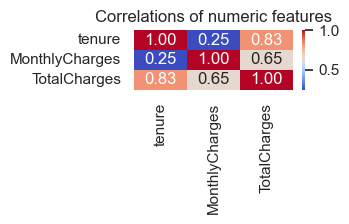

In [49]:
# %%
# 5.6 Correlations of numeric features
if len(num_cols) > 1:
    corr = df_clean[num_cols].corr()
    plt.figure(figsize=(min(12, 1.2*len(num_cols)), min(10, 0.8*len(num_cols))))
    sns.heatmap(corr, annot=True, fmt=".2f", square=False, cmap="coolwarm", cbar=True)
    plt.title("Correlations of numeric features")
    plt.tight_layout()
    plt.savefig(os.path.join(DIRS["figures"], "corr_numeric.png"), dpi=150)
    plt.show()


In [51]:
# %%
# 5.7 Associations of categorical features with churn — Cramér's V
def cramers_v(x, y):
    ct = pd.crosstab(x, y)
    chi2 = chi2_contingency(ct)[0]
    n = ct.sum().sum()
    r, k = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers = []
for c in cat_cols:
    try:
        v = cramers_v(df_clean[c], y)
        cramers.append((c, v))
    except Exception:
        pass

cramers_df = pd.DataFrame(cramers, columns=["feature","cramers_v"]).sort_values("cramers_v", ascending=False)
display(cramers_df.head(15))
cramers_df.to_csv(os.path.join(DIRS["reports"], "cramers_v.csv"), index=False)


,feature,cramers_v
14,Contract,0.409798
8,OnlineSecurity,0.347016
11,TechSupport,0.342526
7,InternetService,0.322037
16,PaymentMethod,0.302677
9,OnlineBackup,0.291850
10,DeviceProtection,0.281095
13,StreamingMovies,0.230351
12,StreamingTV,0.229902
15,PaperlessBilling,0.191141


In [55]:
# %%
# 6) Outliers in numeric features (IQR) + flag/capping
def iqr_outlier_flags(s: pd.Series, k: float = 1.5):
    """Return a boolean mask of outliers and the (low, high) IQR bounds."""
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    return (s < low) | (s > high), (low, high)

outlier_summary = {}
for c in num_cols:
    flags, (low, high) = iqr_outlier_flags(df_clean[c])
    outlier_summary[c] = {"share_outliers_%": flags.mean()*100, "low_cap": low, "high_cap": high}
    # Capping for the modeling copy
    df_clean[c] = np.where(df_clean[c] < low, low, np.where(df_clean[c] > high, high, df_clean[c]))

outlier_df = pd.DataFrame(outlier_summary).T.sort_values("share_outliers_%", ascending=False)
display(outlier_df.round(2))


,share_outliers_%,low_cap,high_cap
tenure,0.0,-60.00,124.00
MonthlyCharges,0.0,-46.02,171.38
TotalCharges,0.0,-4674.34,8863.16


In [57]:
# %%
# 7) Feature engineering (no leakage)
df_feat = df_clean.copy()
df_feat = df_feat.drop(columns=[c for c in ['_y', 'customerID'] if c in df_feat.columns])

# Tenure buckets (if the column exists)
if "tenure" in df_feat.columns:
    df_feat["tenure_bucket"] = pd.cut(
        df_feat["tenure"].astype(float),
        bins=[-1, 6, 12, 24, 48, 72, np.inf],
        labels=["<=6m", "7-12m", "13-24m", "25-48m", "49-72m", ">72m"]
    )

# Services count: count how many services are enabled (logic for classic Telco fields)
service_like = [c for c in df_feat.columns if any(k in c.lower() for k in
                    ["security", "backup", "protection", "techsupport", "streaming", "internet", "phone", "lines"])]

def yes_no_to01(val):
    s = str(val).strip().lower()
    if s in ["yes", "true", "1"]:
        return 1
    elif s in ["no", "false", "0", "unknown", "no internet service", "no phone service"]:
        return 0
    return 0

if service_like:
    df_feat["services_count"] = df_feat[service_like].applymap(yes_no_to01).sum(axis=1)

# Binary conveniences (convert to 0/1)
for col in ["PaperlessBilling", "Partner", "Dependents"]:
    if col in df_feat.columns:
        df_feat[col + "_bin"] = df_feat[col].map(yes_no_to01)

# Target as y
y = df_feat[TARGET].map(yes_no_to01)

# Формируем X из того же df_feat и выкидываем всё лишнее
X = df_feat.drop(columns=[c for c in [TARGET, '_y', 'customerID'] if c in df_feat.columns],
                 errors='ignore').copy()

# Списки признаков (из X)
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

# (если ниже у тебя код использует именно num_cols/cat_cols — сделай алиасы)
num_cols = numeric_features
cat_cols = categorical_features


In [59]:
# %%
# 8) Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Churn share in train/test:", round(y_train.mean(), 3), round(y_test.mean(), 3))


Train shape: (5634, 24)  Test shape: (1409, 24)
Churn share in train/test: 0.265 0.265


In [61]:
# %%
# 9) Preprocessing pipeline + Baseline model (Logistic Regression)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True)),  # <— was `sparse=True`
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
)

logreg_clf = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])

# Train
logreg_clf.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'services_count']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore...
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_bucket',
                                                   'PaperlessBilling_bin',
                                                   'Partner_bin',
                                                   'Dependents_bin'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=200))])

In [63]:
# === FIX: расширенный тюнинг и обучение нескольких моделей ===
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Опционально: XGBoost/LightGBM — подключатся, если установлены
has_xgb = has_lgbm = False
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    pass

try:
    import lightgbm as lgbm
    has_lgbm = True
except Exception:
    pass

RANDOM_STATE = 42

# Для небаланса (полезно XGBoost): оценим вес класса 1
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# --- Пайплайны моделей ---
pipe_lr = Pipeline([
    ("pre", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)),
])

pipe_rf = Pipeline([
    ("pre", preprocess),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE)),
])

pipe_gb = Pipeline([
    ("pre", preprocess),
    ("clf", GradientBoostingClassifier(random_state=RANDOM_STATE)),
])

pipe_svc = Pipeline([
    ("pre", preprocess),
    ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)),
])

pipe_knn = Pipeline([
    ("pre", preprocess),
    ("clf", KNeighborsClassifier()),
])

if has_xgb:
    pipe_xgb = Pipeline([
    ("pre", preprocess),
    ("clf", xgb.XGBClassifier(
        # objective по умолчанию у XGBClassifier для бинарной задачи — 'binary:logistic'
        eval_metric="logloss",      # можно оставить 'logloss' или поставить 'auc'
        tree_method="hist",
        random_state=RANDOM_STATE,
        scale_pos_weight=scale_pos_weight,
        # use_label_encoder — НЕ указывать
    )),
])

if has_lgbm:
    pipe_lgbm = Pipeline([
        ("pre", preprocess),
        ("clf", lgbm.LGBMClassifier(
            class_weight="balanced",
            random_state=RANDOM_STATE
        )),
    ])

# --- Сетки гиперпараметров ---
param_grid_lr = {
    "clf__C": [0.1, 1.0, 3.0, 10.0],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "liblinear"],
}

param_grid_rf = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}

param_grid_gb = {
    "clf__n_estimators": [200, 400],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [2, 3],
    "clf__subsample": [0.8, 1.0],
}

param_grid_svc = {
    "clf__C": [0.5, 1.0, 2.0],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf"],
}

param_grid_knn = {
    "clf__n_neighbors": [5, 15, 31],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2],  # 1=манхэттен, 2=евклид
}

if has_xgb:
    param_grid_xgb = {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [3, 6],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }

if has_lgbm:
    param_grid_lgbm = {
        "clf__n_estimators": [300, 600],
        "clf__num_leaves": [31, 63],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }

# --- Рoster кандидатов ---
candidates = [
    ("LogisticRegression", pipe_lr, param_grid_lr),
    ("RandomForest",      pipe_rf, param_grid_rf),
    ("GradientBoosting",  pipe_gb, param_grid_gb),
    ("SVC",               pipe_svc, param_grid_svc),
    ("KNN",               pipe_knn, param_grid_knn),
]
if has_xgb:
    candidates.append(("XGBoost", pipe_xgb, param_grid_xgb))
if has_lgbm:
    candidates.append(("LightGBM", pipe_lgbm, param_grid_lgbm))

# --- GridSearch для всех моделей ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
for name, pipe, grid in candidates:
    print(f"\n=== GridSearch {name} ===")
    gs = GridSearchCV(pipe, grid, scoring="roc_auc", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(X_train, y_train)

    # Метрики на hold-out
    y_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)

    print(f"best_params={gs.best_params_} | AUC={auc:.3f} | F1={f1:.3f} | Acc={acc:.3f}")
    results.append((name, gs.best_estimator_, gs.best_params_, auc, f1, acc))

# --- Выбор и отчёт по лучшей модели ---
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)  # сортируем по AUC
best_name, best_est, best_params, best_auc, best_f1, best_acc = results_sorted[0]
print(f"\nBest model: {best_name} | AUC={best_auc:.3f} | F1={best_f1:.3f} | Acc={best_acc:.3f}")
print("Best params:", best_params)



=== GridSearch LogisticRegression ===
best_params={'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'} | AUC=0.845 | F1=0.620 | Acc=0.740

=== GridSearch RandomForest ===
best_params={'clf__max_depth': 10, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 400} | AUC=0.841 | F1=0.624 | Acc=0.767

=== GridSearch GradientBoosting ===
best_params={'clf__learning_rate': 0.05, 'clf__max_depth': 2, 'clf__n_estimators': 200, 'clf__subsample': 0.8} | AUC=0.847 | F1=0.588 | Acc=0.805

=== GridSearch SVC ===
best_params={'clf__C': 0.5, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'} | AUC=0.838 | F1=0.617 | Acc=0.797

=== GridSearch KNN ===
best_params={'clf__n_neighbors': 31, 'clf__p': 1, 'clf__weights': 'uniform'} | AUC=0.829 | F1=0.587 | Acc=0.785

=== GridSearch XGBoost ===
best_params={'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 0.8} | AUC=0.843 | F1=0.624 | Acc=0.748

=== Gri


[LogReg] Metrics:
  roc_auc_train: 0.8521
  roc_auc_test: 0.8448
  pr_auc_test: 0.6505
  f1_test: 0.6211
  precision_test: 0.5068
  recall_test: 0.8021


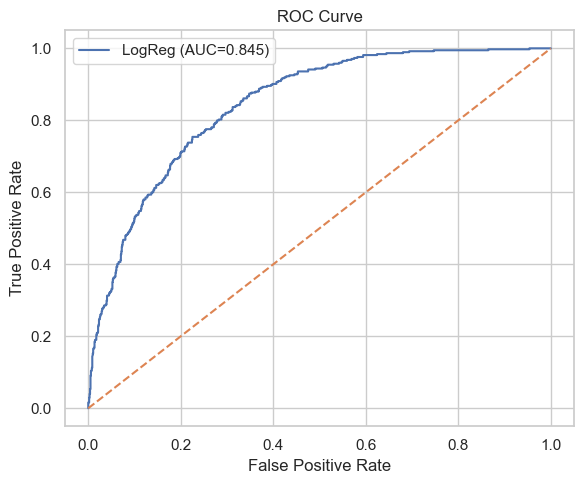

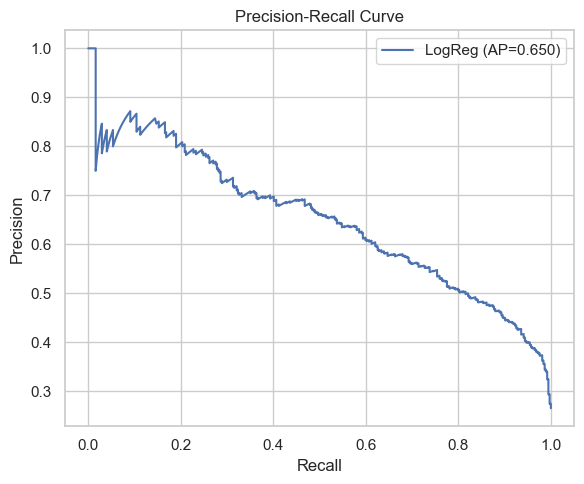

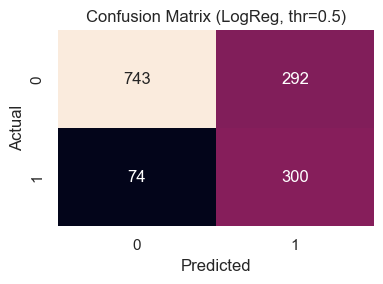


Classification report:
               precision    recall  f1-score   support

           0      0.909     0.718     0.802      1035
           1      0.507     0.802     0.621       374

    accuracy                          0.740      1409
   macro avg      0.708     0.760     0.712      1409
weighted avg      0.803     0.740     0.754      1409



In [65]:
# %%
# 10) Model evaluation (ROC-AUC, PR-AUC, F1, precision, recall) + plots
def evaluate_model(model, X_tr, y_tr, X_te, y_te, label: str):
    ytr_p = model.predict_proba(X_tr)[:,1]
    yte_p = model.predict_proba(X_te)[:,1]
    yte_hat = (yte_p >= 0.5).astype(int)

    metrics = {
        "roc_auc_train": roc_auc_score(y_tr, ytr_p),
        "roc_auc_test": roc_auc_score(y_te, yte_p),
        "pr_auc_test": average_precision_score(y_te, yte_p),
        "f1_test": f1_score(y_te, yte_hat),
        "precision_test": precision_score(y_te, yte_hat),
        "recall_test": recall_score(y_te, yte_hat)
    }
    print(f"\n[{label}] Metrics:")
    for k,v in metrics.items():
        print(f"  {k}: {v:.4f}")

    # ROC
    fpr, tpr, _ = roc_curve(y_te, yte_p)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{label} (AUC={metrics['roc_auc_test']:.3f})")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(DIRS["figures"], f"roc__{label}.png"), dpi=150); plt.show()

    # PR
    pr, rc, _ = precision_recall_curve(y_te, yte_p)
    ap = metrics['pr_auc_test']
    plt.figure(figsize=(6,5))
    plt.plot(rc, pr, label=f"{label} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(DIRS["figures"], f"pr__{label}.png"), dpi=150); plt.show()

    # Confusion Matrix при пороге 0.5
    cm = confusion_matrix(y_te, yte_hat)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.title(f"Confusion Matrix ({label}, thr=0.5)")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.savefig(os.path.join(DIRS["figures"], f"cm__{label}.png"), dpi=150); plt.show()

    print("\nClassification report:\n", classification_report(y_te, yte_hat, digits=3))
    return metrics

metrics_lr = evaluate_model(logreg_clf, X_train, y_train, X_test, y_test, "LogReg")

In [66]:
# 11) Feature interpretation (LR coefficients) — robust

# Возьмите ваш обученный пайплайн
fitted_pipe = logreg_clf   # или best_est / rf_clf и т.п.
pre = fitted_pipe.named_steps["pre"]
clf = fitted_pipe.named_steps["clf"]

# 1) Получаем итоговые имена признаков
try:
    # sklearn >= 1.0: у ColumnTransformer есть удобный метод
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # Fallback (старые версии): собираем имена через OHE и списки колонок в CT
    cat_pipe = pre.named_transformers_["cat"]
    ohe = cat_pipe.named_steps["onehot"]
    # имена входных категориальных признаков, на которых OHE был обучен
    try:
        cat_in = ohe.feature_names_in_
    except AttributeError:
        # ещё один fallback: достанем список колонок из самого ColumnTransformer
        cat_in = pre.transformers_[pre._name_to_fitted_ix["cat"]][2]
    cat_names = ohe.get_feature_names_out(cat_in)

    # имена числовых признаков, на которых обучался числовой пайплайн
    num_in = pre.transformers_[pre._name_to_fitted_ix["num"]][2]
    feature_names = np.array(list(num_in) + list(cat_names))

# 2) Коэффициенты LR
coefs = clf.coef_.ravel()
assert len(coefs) == len(feature_names), f"Mismatch: {len(coefs)} coefs vs {len(feature_names)} features"

coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})

# Топы
top_pos = coef_df.sort_values("coef", ascending=False).head(15)
top_neg = coef_df.sort_values("coef", ascending=True).head(15)

display(top_pos)
display(top_neg)

# 3) Сохранение (без лишней точки в конце строки!)
out_path = os.path.join(DIRS["reports"], "logreg_coefs.csv")
coef_df.to_csv(out_path, index=False)
print("Saved:", out_path)

,feature,coef
18,cat__InternetService_Fiber optic,0.817317
38,cat__Contract_Month-to-month,0.793375
51,cat__tenure_bucket_<=6m,0.616060
3,num__services_count,0.311770
20,cat__OnlineSecurity_No,0.306367
37,cat__StreamingMovies_Yes,0.292363
45,cat__PaymentMethod_Electronic check,0.287333
34,cat__StreamingTV_Yes,0.279475
29,cat__TechSupport_No,0.273974
23,cat__OnlineBackup_No,0.198360


,feature,coef
40,cat__Contract_Two year,-0.818077
1,num__MonthlyCharges,-0.619796
17,cat__InternetService_DSL,-0.608936
0,num__tenure,-0.542920
48,cat__tenure_bucket_25-48m,-0.258614
47,cat__tenure_bucket_13-24m,-0.220084
27,cat__DeviceProtection_No internet service,-0.174790
30,cat__TechSupport_No internet service,-0.174790
21,cat__OnlineSecurity_No internet service,-0.174790
19,cat__InternetService_No,-0.174790


Saved: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/reports/logreg_coefs.csv



[RandomForest] Metrics:
  roc_auc_train: 0.9998
  roc_auc_test: 0.8204
  pr_auc_test: 0.6049
  f1_test: 0.5250
  precision_test: 0.6070
  recall_test: 0.4626


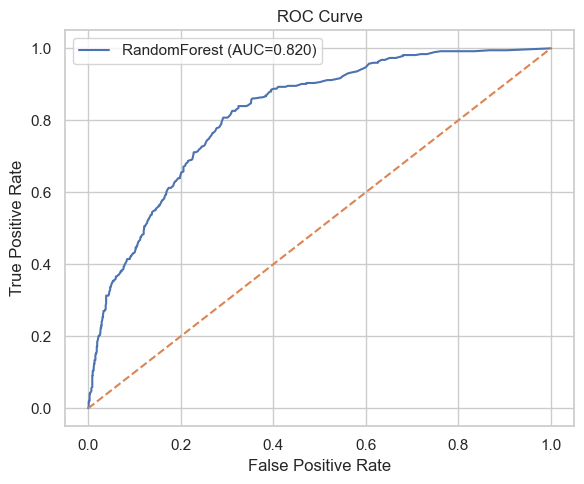

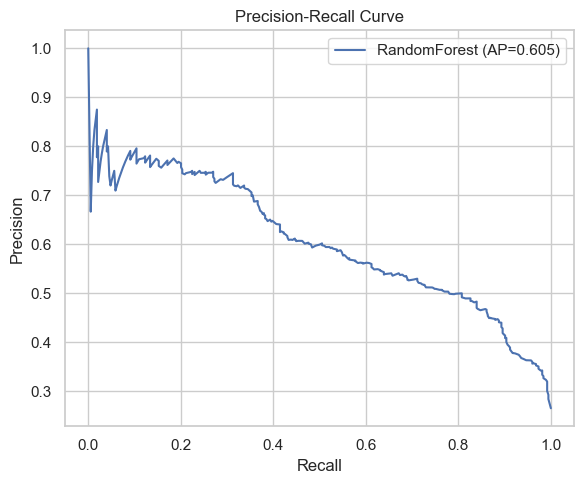

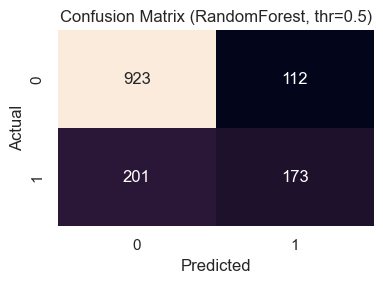


Classification report:
               precision    recall  f1-score   support

           0      0.821     0.892     0.855      1035
           1      0.607     0.463     0.525       374

    accuracy                          0.778      1409
   macro avg      0.714     0.677     0.690      1409
weighted avg      0.764     0.778     0.767      1409



,feature,importance
2,num__TotalCharges,0.118748
1,num__MonthlyCharges,0.108982
0,num__tenure,0.103137
38,cat__Contract_Month-to-month,0.066076
40,cat__Contract_Two year,0.031816
18,cat__InternetService_Fiber optic,0.029910
3,num__services_count,0.029796
29,cat__TechSupport_No,0.029559
20,cat__OnlineSecurity_No,0.028824
45,cat__PaymentMethod_Electronic check,0.026613


In [67]:
# %%
# 12) Second simple baseline (optional): RandomForest
rf_clf = Pipeline(steps=[
    ("pre", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced_subsample",
        max_depth=None, n_jobs=-1
    ))
])
rf_clf.fit(X_train, y_train)
metrics_rf = evaluate_model(rf_clf, X_train, y_train, X_test, y_test, "RandomForest")

# RF feature importances
rf_model: RandomForestClassifier = rf_clf.named_steps["clf"]
importances = rf_model.feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
display(fi_df.head(25))
fi_df.to_csv(os.path.join(DIRS["reports"], "rf_feature_importances.csv"), index=False)


In [68]:
# %%
# 13) Saving the processed dataset and metrics
processed_path = os.path.join(DIRS["data_processed"], "telco_processed.csv")
df_feat.assign(**{TARGET: y}).to_csv(processed_path, index=False)

metrics_path = os.path.join(DIRS["reports"], "metrics.json")
with open(metrics_path, "w") as f:
    json.dump({"logreg": metrics_lr, "rf": metrics_rf}, f, indent=2)

print("Saved:")
print(" -", processed_path)
print(" -", metrics_path)


Saved:
 - /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/data/processed/telco_processed.csv
 - /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/reports/metrics.json


In [69]:
# --- parameters and column selection ---
import math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source_df = df_clean.copy()          # if you want, put X_train here
target = TARGET if TARGET in source_df.columns else None

# numeric columns for histograms (exclude binary 0/1)
num_cols_plot = [c for c in source_df.select_dtypes(include=np.number).columns
                 if (target is None or c != target) and source_df[c].nunique(dropna=True) > 2]

# categorical + binary numeric
cat_cols_plot = list(source_df.select_dtypes(include=["object","category","bool"]).columns)
bin_num_as_cat = [c for c in source_df.select_dtypes(include=np.number).columns
                  if source_df[c].nunique(dropna=True) <= 2 and (target is None or c != target)]
cat_cols_plot = [c for c in cat_cols_plot if (target is None or c != target)] + bin_num_as_cat

# where to save
fig_dir = os.path.join(DIRS["figures"] if "DIRS" in globals() else "figures")
os.makedirs(fig_dir, exist_ok=True)


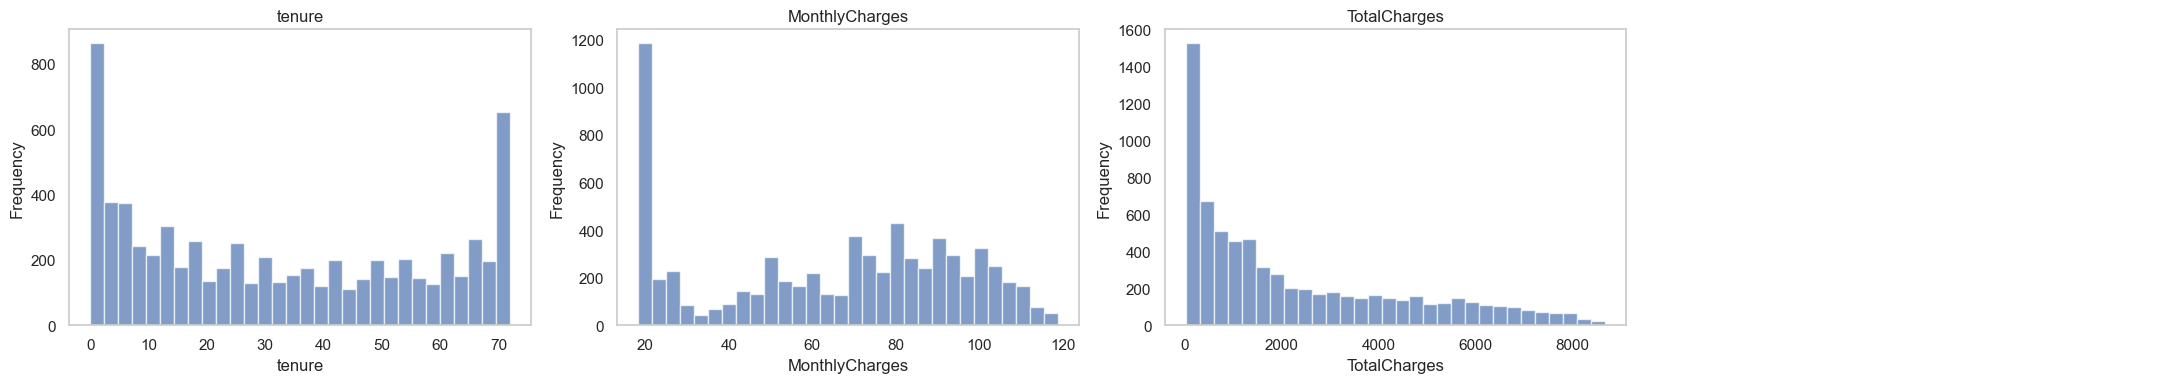

Saved: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/figures/univariate_numeric_grid.png


In [70]:
# --- HIST: numeric ---
cols = num_cols_plot
n = len(cols)
cols_per_row = 4
rows = math.ceil(n / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(22, 4*rows))
axes = np.array(axes).reshape(rows, cols_per_row)

for i, c in enumerate(cols):
    r, k = divmod(i, cols_per_row)
    ax = axes[r, k]
    source_df[c].plot(kind="hist", bins=30, alpha=0.7, ax=ax)
    ax.set_title(c)
    ax.set_xlabel(c)
    ax.grid(False)

# hide empty cells
for j in range(n, rows*cols_per_row):
    r, k = divmod(j, cols_per_row)
    axes[r, k].axis("off")

plt.tight_layout()
out_path_num = os.path.join(fig_dir, "univariate_numeric_grid.png")
plt.savefig(out_path_num, dpi=150)
plt.show()
print("Saved:", out_path_num)


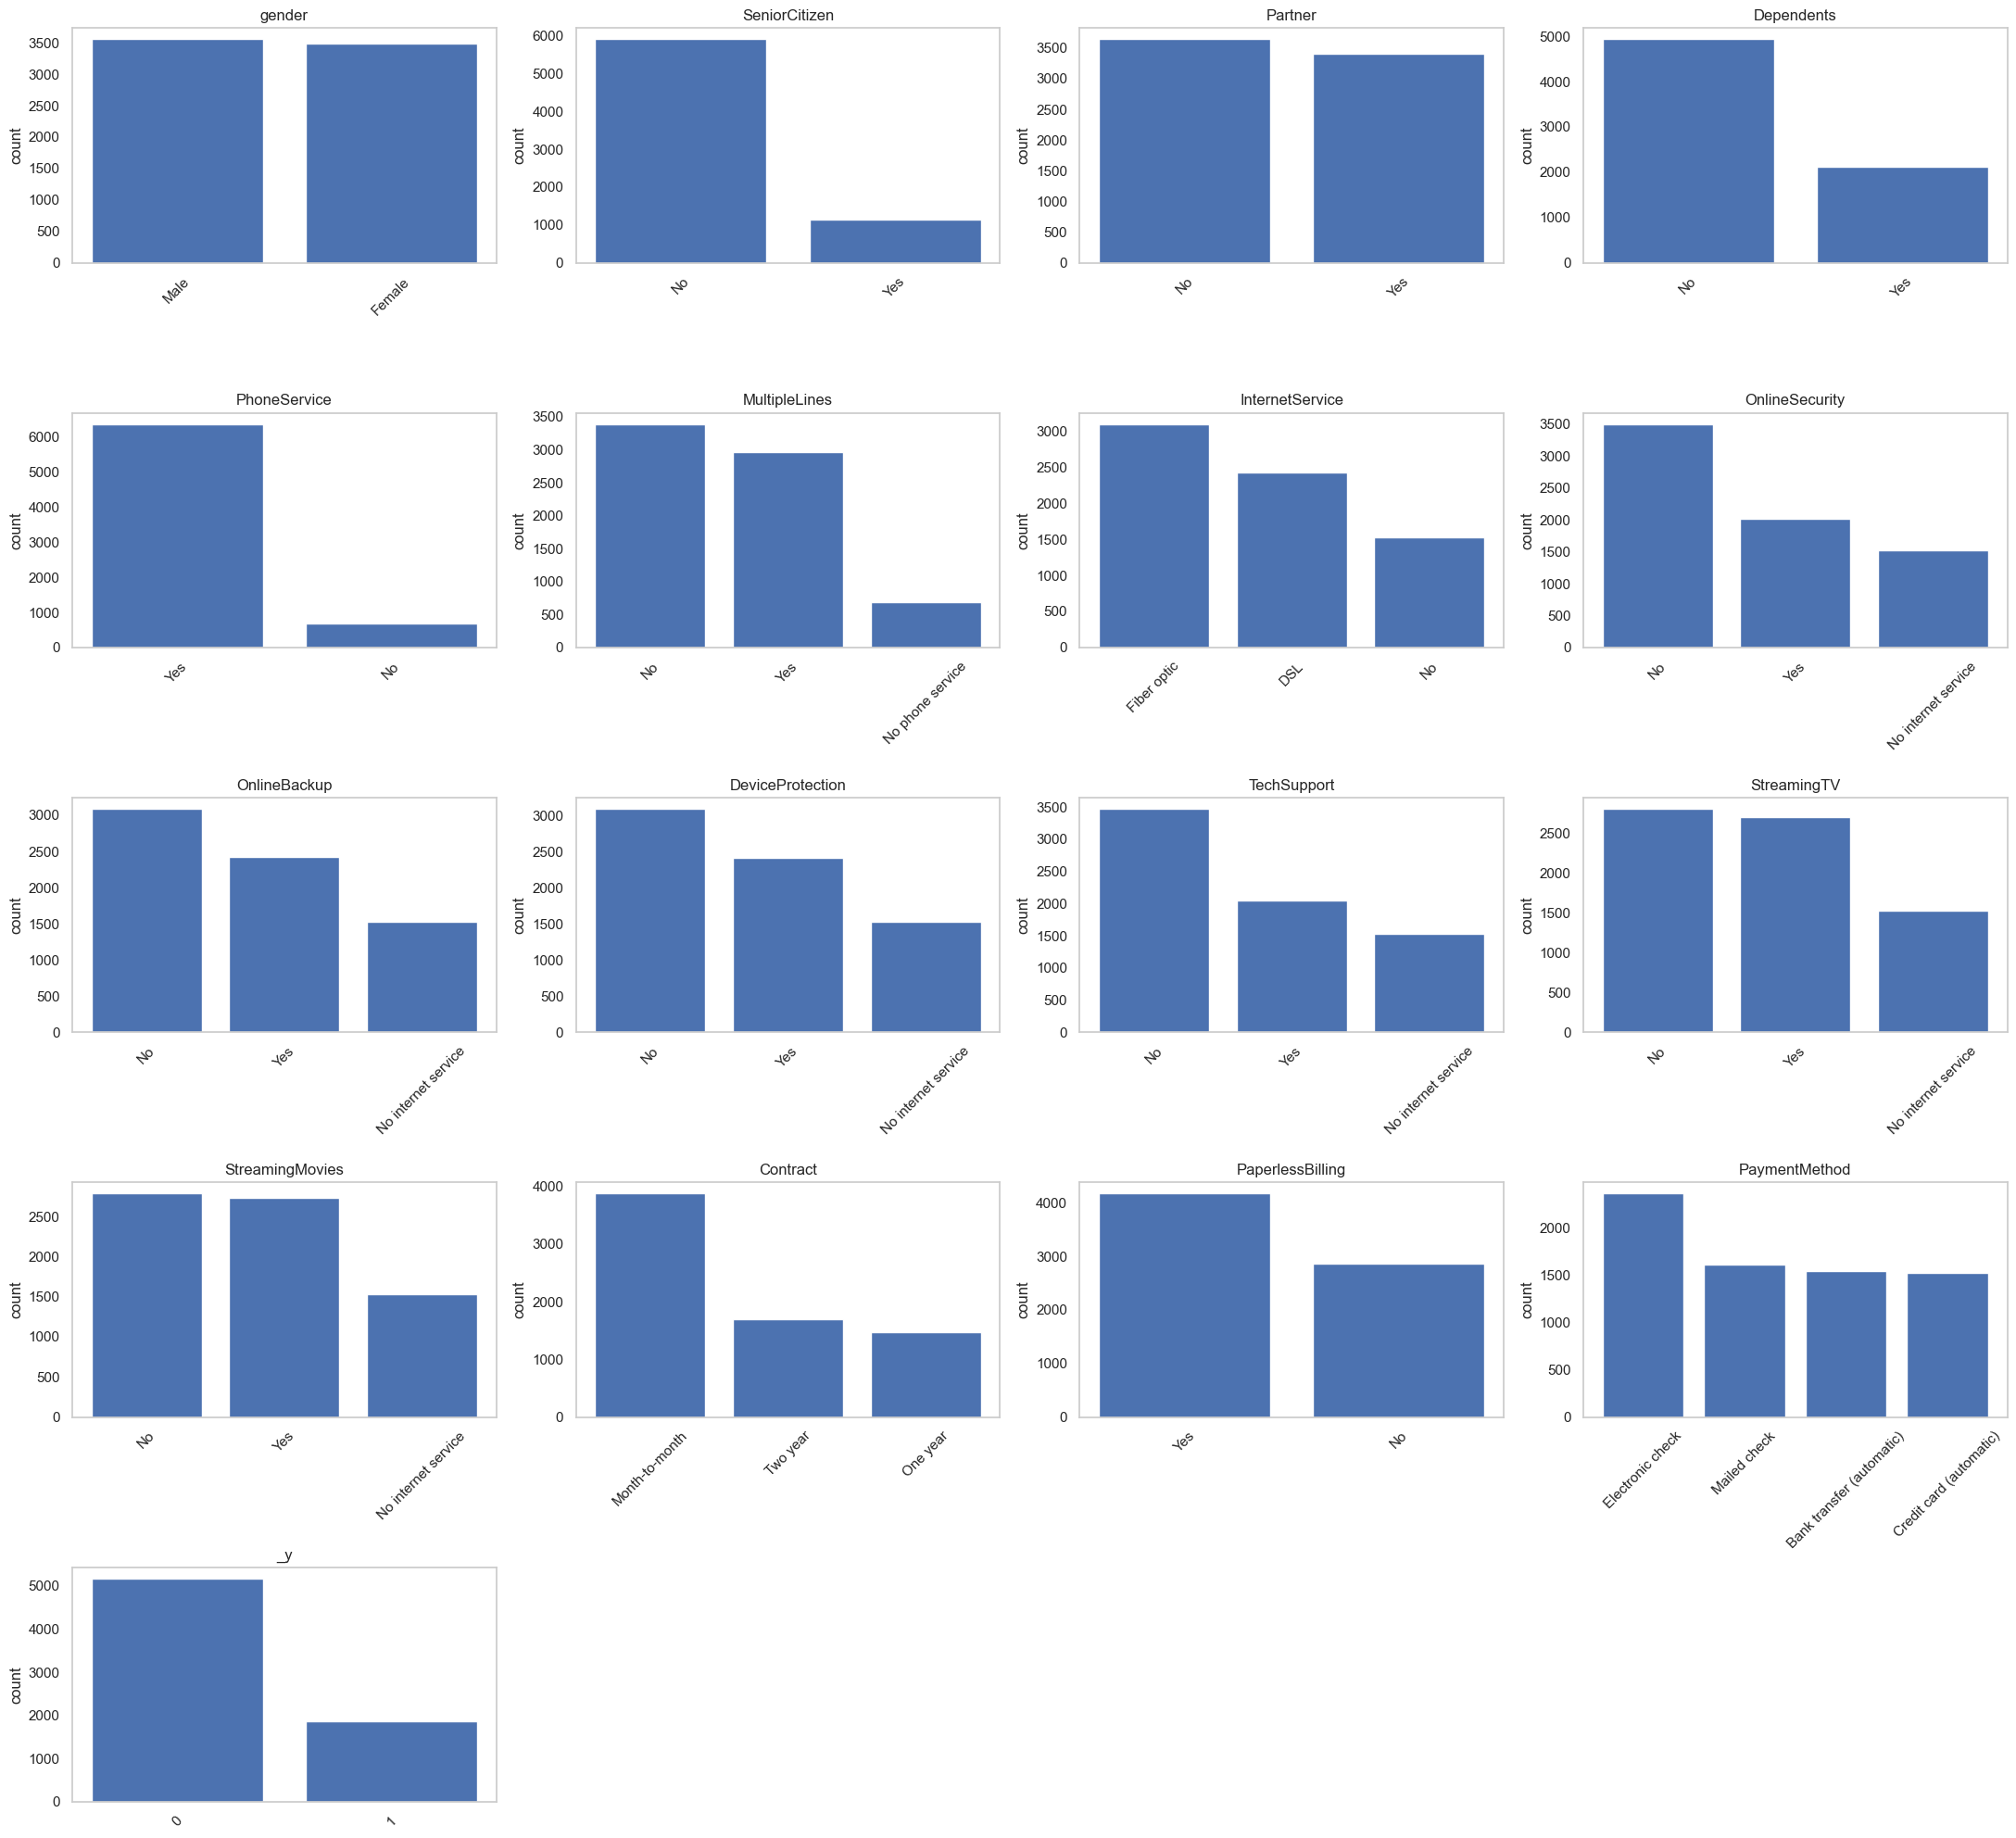

Saved: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/figures/univariate_categorical_grid_FAST.png


In [71]:
# --- Fast grid of bar charts for categorical features ---
import math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

source_df = df_clean  # you can switch to X_train if desired
fig_dir = os.path.join(DIRS["figures"] if "DIRS" in globals() else "figures")
os.makedirs(fig_dir, exist_ok=True)

# Performance / readability parameters
MAX_LEVELS = 40        # keep only features with <= 40 categories
TOP_K = 12             # show TOP_K categories (others -> "Other")
MIN_COUNT = 20         # ignore categories with frequency < MIN_COUNT
COLS_PER_ROW = 4       # number of columns per row in the grid
SAMPLE_N = None        # e.g., 40000 for very large datasets

df_vis = source_df.sample(SAMPLE_N, random_state=42) if SAMPLE_N else source_df

# Select categorical + binary numeric features
cat_cols_plot = list(df_vis.select_dtypes(include=["object","category","bool"]).columns)
bin_num_as_cat = [c for c in df_vis.select_dtypes(include=np.number).columns
                  if df_vis[c].nunique(dropna=True) <= 2 and c != TARGET]
cat_cols_plot = [c for c in cat_cols_plot if c != TARGET] + bin_num_as_cat
cat_cols_plot = [c for c in cat_cols_plot if df_vis[c].nunique(dropna=False) <= MAX_LEVELS]

def fast_value_counts_cat(col: pd.Series, top_k=TOP_K, min_count=MIN_COUNT,
                          other_label="Other") -> pd.Series:
    """Very fast category frequency count with tail aggregation."""
    cat = col.astype("category")
    codes = cat.cat.codes.to_numpy()
    mask = codes != -1
    codes = codes[mask]
    counts = np.bincount(codes, minlength=len(cat.cat.categories))
    # sort descending
    order = np.argsort(counts)[::-1]
    cats = np.array(cat.cat.categories)[order]
    cnts = counts[order]
    # filter rare categories
    if min_count and min_count > 1:
        keep = cnts >= min_count
        cats, cnts = cats[keep], cnts[keep]
    # limit to top_k and aggregate the tail
    if top_k and len(cnts) > top_k:
        other_sum = cnts[top_k:].sum()
        cats = np.concatenate([cats[:top_k], [other_label]])
        cnts = np.concatenate([cnts[:top_k], [other_sum]])
    return pd.Series(cnts, index=cats)

# Build the grid
n = len(cat_cols_plot)
rows = math.ceil(n / COLS_PER_ROW)
fig, axes = plt.subplots(rows, COLS_PER_ROW, figsize=(22, 4*rows))
axes = np.atleast_2d(axes)

for i, c in enumerate(cat_cols_plot):
    ax = axes.flat[i]
    vc = fast_value_counts_cat(df_vis[c])
    ax.bar(vc.index.astype(str), vc.values)
    ax.set_title(c)
    ax.set_ylabel("count")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(False)

# hide empty axes
for j in range(n, rows*COLS_PER_ROW):
    axes.flat[j].axis("off")

plt.tight_layout()
out_path_cat = os.path.join(fig_dir, "univariate_categorical_grid_FAST.png")
plt.savefig(out_path_cat, dpi=150)
plt.show()
print("Saved:", out_path_cat)


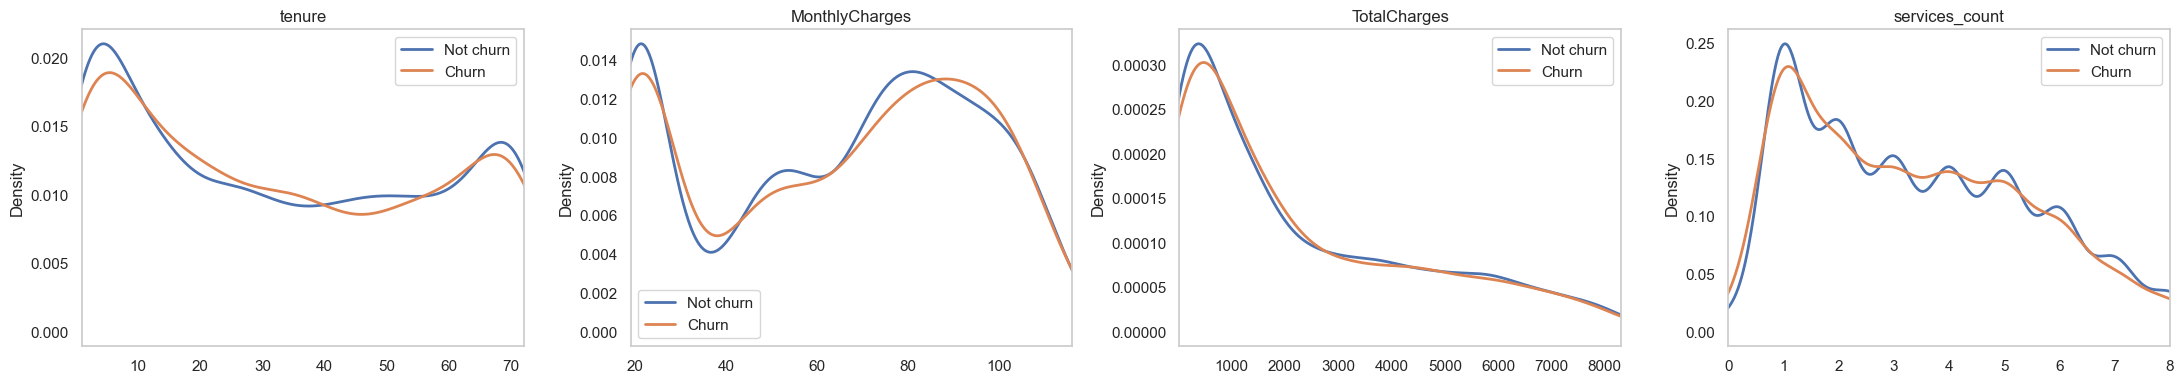

Saved: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/figures/univariate_density_grid_OVERLAY.png


In [72]:
# Fast and controllable KDE grid; you can overlay Churn / Not Churn curves
import os, math, numpy as np, matplotlib.pyplot as plt

source_df = X_train if "X_train" in globals() else df_clean.copy()

# target (0/1), if available
y_series = None
if "TARGET" in globals() and TARGET in df_clean.columns:
    # take the binary target from the original df_clean; it may be absent in X_train
    y_series = df_clean[TARGET].map(lambda v: 1 if str(v).strip().lower() in ["yes","true","1"] else 0)

# columns for KDE (can exclude binary)
skip_binary = False
num_cols_kde = []
for c in source_df.select_dtypes(include=np.number).columns:
    if c == TARGET: 
        continue
    nunq = source_df[c].nunique(dropna=True)
    if skip_binary and nunq <= 2:
        continue
    num_cols_kde.append(c)

# sampling for speed
SAMPLE_N = 40000
df_vis = (source_df.sample(SAMPLE_N, random_state=42)
          if len(source_df) > SAMPLE_N else source_df).copy()
df_vis[num_cols_kde] = df_vis[num_cols_kde].replace([np.inf, -np.inf], np.nan)

cols_per_row = 4
rows = max(1, math.ceil(len(num_cols_kde) / cols_per_row))
fig, axes = plt.subplots(rows, cols_per_row, figsize=(22, 4*rows))
axes = np.atleast_2d(axes)

# Percentile-based limits for readability
def smart_xlim(s: np.ndarray, q_low=0.005, q_high=0.995):
    s = s[~np.isnan(s)]
    if s.size == 0:
        return None
    lo, hi = np.quantile(s, [q_low, q_high])
    return (lo, hi) if np.isfinite(lo) and np.isfinite(hi) and lo < hi else None

for i, c in enumerate(num_cols_kde):
    ax = axes.flat[i]
    series = df_vis[c].astype(float)

    if y_series is not None and len(y_series) == len(df_clean):
        # overlay by churn classes (if target available)
        # choose x-limits from all data
        xlim = smart_xlim(series.to_numpy())
        for cls, lbl in [(0, "Not churn"), (1, "Churn")]:
            mask = (y_series == cls).values[:len(series)]  # align lengths just in case
            s = series[mask] if mask.sum() > 0 else series.iloc[:0]
            if s.notna().sum() > 1:
                s.plot(kind="kde", ax=ax, label=lbl, linewidth=2)
        if xlim: ax.set_xlim(*xlim)
        ax.legend()
    else:
        # single KDE
        if series.notna().sum() > 1:
            series.plot(kind="kde", ax=ax, linewidth=2)

    ax.set_title(c)
    ax.set_ylabel("Density")
    ax.grid(False)

# hide empty axes
for j in range(len(num_cols_kde), rows*cols_per_row):
    axes.flat[j].axis("off")

out_path = os.path.join(DIRS["figures"], "univariate_density_grid_OVERLAY.png")
plt.tight_layout()
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)


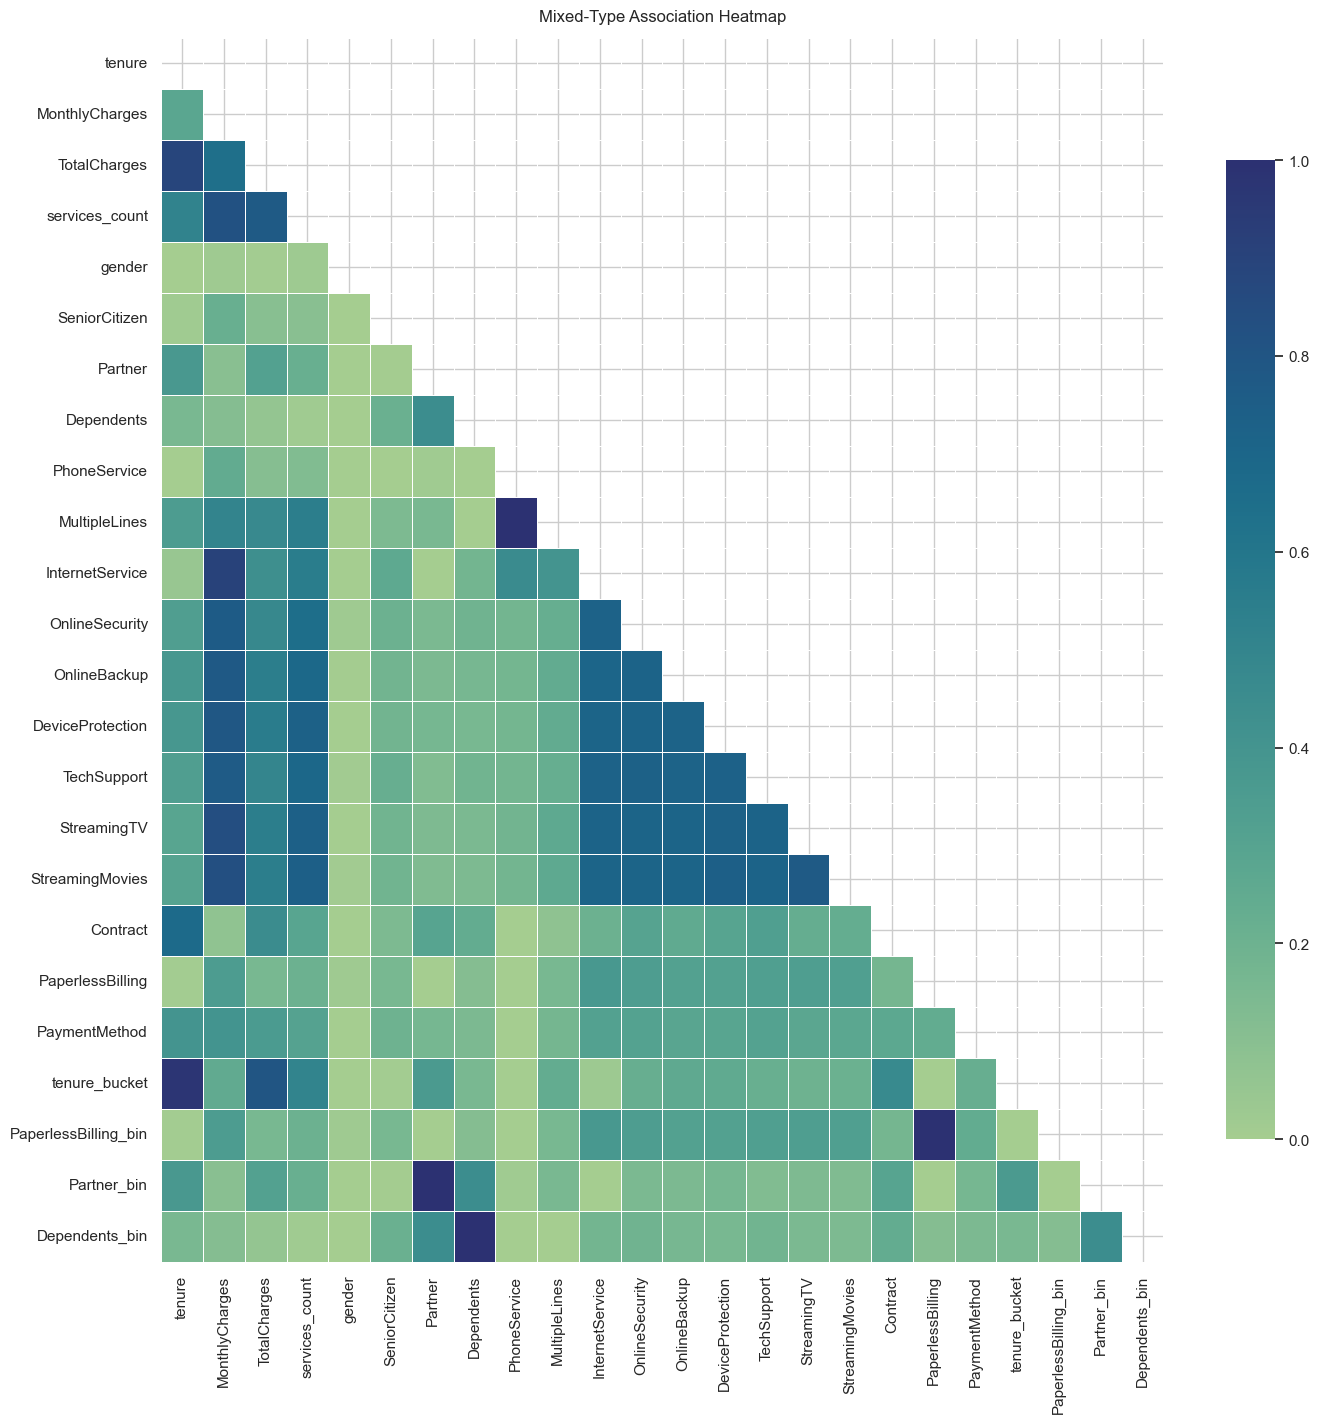

Saved: /Users/ilya/Documents/Course Berkeley AI:ML/Capstone Project/churn-capstone-result/churn-capstone/figures/mixed_association_heatmap.png


In [73]:
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy.stats import chi2_contingency

source_df = (X_train.copy() if "X_train" in globals()
             else df_clean.drop(columns=[TARGET], errors="ignore").copy())

SAMPLE_N = 40000
MAX_CATS = 50
ABS_FOR_NUM_NUM = True
ANNOT_LIMIT = 22
FIG_DIR = os.path.join(DIRS["figures"] if "DIRS" in globals() else "figures")
os.makedirs(FIG_DIR, exist_ok=True)

if SAMPLE_N and len(source_df) > SAMPLE_N:
    source_df = source_df.sample(SAMPLE_N, random_state=42)

num_cols = list(source_df.select_dtypes(include=np.number).columns)
cat_cols = list(source_df.select_dtypes(include=["object","category","bool"]).columns)

def compress_categories(s: pd.Series, max_cats: int = 50, other_label: str = "Other") -> pd.Series:
    s = s.astype("category")
    if s.nunique(dropna=False) > max_cats:
        top = s.value_counts(dropna=False).nlargest(max_cats - 1).index
        if other_label not in list(s.cat.categories):
            s = s.cat.add_categories([other_label])
        s = s.where(s.isin(top), other_label)
        s = s.cat.remove_unused_categories()
    return s

for c in cat_cols:
    source_df[c] = compress_categories(source_df[c], MAX_CATS, "Other")

cols = num_cols + cat_cols

def cramers_v_corrected(x, y):
    ct = pd.crosstab(x, y)
    if ct.size == 0:
        return np.nan
    chi2 = chi2_contingency(ct)[0]
    n = ct.values.sum()
    r, k = ct.shape
    if n <= 1 or r <= 1 or k <= 1:
        return 0.0
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else 0.0

def correlation_ratio(categories: pd.Series, measurements: pd.Series) -> float:
    cats, _ = pd.factorize(categories, sort=False)
    m = pd.to_numeric(measurements, errors="coerce").to_numpy()
    mask = (~np.isnan(m)) & (cats != -1)
    cats = cats[mask]; m = m[mask]
    if m.size == 0:
        return np.nan
    n_cats = cats.max() + 1
    if n_cats <= 1:
        return 0.0
    grand = m.mean()
    ss_between = 0.0
    for k in range(n_cats):
        vals = m[cats == k]
        if vals.size:
            ss_between += vals.size * (vals.mean() - grand) ** 2
    ss_total = ((m - grand) ** 2).sum()
    return 0.0 if ss_total == 0 else float(np.sqrt(ss_between / ss_total))

assoc = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols, dtype=float)

for i, ci in enumerate(cols):
    for j in range(i+1, len(cols)):
        cj = cols[j]
        si, sj = source_df[ci], source_df[cj]
        if ci in num_cols and cj in num_cols:
            val = si.corr(sj, method="spearman")
            if ABS_FOR_NUM_NUM and pd.notna(val): val = abs(val)
        elif ci in cat_cols and cj in cat_cols:
            val = cramers_v_corrected(si, sj)
        else:
            val = correlation_ratio(si, sj) if ci in cat_cols else correlation_ratio(sj, si)
        assoc.iloc[i, j] = val
        assoc.iloc[j, i] = val

vmin, vmax = (0, 1) if ABS_FOR_NUM_NUM else (-1, 1)
annot_flag = assoc.shape[0] <= ANNOT_LIMIT
mask = np.triu(np.ones_like(assoc, dtype=bool))

plt.figure(figsize=(max(10, 0.6*len(cols)), max(8, 0.6*len(cols))))
sns.heatmap(assoc, mask=mask, vmin=vmin, vmax=vmax, cmap="crest",
            annot=annot_flag, fmt=".2f" if annot_flag else "",
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Mixed-Type Association Heatmap", pad=12)
plt.tight_layout()
out_path = os.path.join(FIG_DIR, "mixed_association_heatmap.png")
plt.savefig(out_path, dpi=150)
plt.show()
print("Saved:", out_path)


In [74]:
# Import/install imbalanced-learn
import sys, subprocess
try:
    import imblearn  # noqa: F401
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [75]:
# Models: LR, DT, RF, GB, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

def get_models(class_weight=None):
    """Returns a dictionary of models. class_weight is applied where supported."""
    models = {
        "LogReg": LogisticRegression(max_iter=500, class_weight=class_weight),
        "DecisionTree": DecisionTreeClassifier(class_weight=class_weight, random_state=42),
        "RandomForest": RandomForestClassifier(
            n_estimators=400, random_state=42, n_jobs=-1, class_weight=class_weight
        ),
        # HistGradientBoosting does not always support class_weight — use resampling for it
        "HistGB": HistGradientBoostingClassifier(random_state=42),
        # SVM can be slow on large datasets; probability=True is needed for ROC AUC
        "SVM": SVC(kernel="rbf", probability=True, class_weight=class_weight, random_state=42),
    }
    return models


In [76]:
# Imbalance handling strategies
imbalance_strategies = {
    "none": None,                                    # no resampling/weights
    "class_weight": None,                            # only class weights inside the model
    "oversample": RandomOverSampler(random_state=42),
    "smote": SMOTE(random_state=42, k_neighbors=5),
    "undersample": RandomUnderSampler(random_state=42),
}


In [77]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import matplotlib.pyplot as plt, os

fig_dir = os.path.join(DIRS["figures"] if "DIRS" in globals() else "figures")
os.makedirs(fig_dir, exist_ok=True)

def eval_on_test(clf, X_tr, y_tr, X_te, y_te, label):
    # probability (or score) predictions for ROC AUC
    if hasattr(clf, "predict_proba"):
        p_te = clf.predict_proba(X_te)[:, 1]
    else:
        # for models without predict_proba: map decision_function to [0,1] via min-max
        s = clf.decision_function(X_te)
        s = (s - s.min()) / (s.max() - s.min() + 1e-9)
        p_te = s
    y_hat = (p_te >= 0.5).astype(int)

    return {
        "label": label,
        "roc_auc": roc_auc_score(y_te, p_te),
        "precision": precision_score(y_te, y_hat, zero_division=0),
        "recall": recall_score(y_te, y_hat, zero_division=0),
        "f1": f1_score(y_te, y_hat, zero_division=0),
        "probs": p_te,  # return for ROC plotting
    }

def plot_roc_curves(curves, title, out_name):
    plt.figure(figsize=(7,6))
    for lab, y_true, p in curves:
        fpr, tpr, _ = roc_curve(y_true, p)
        auc = roc_auc_score(y_true, p)
        plt.plot(fpr, tpr, label=f"{lab} (AUC={auc:.3f})", linewidth=2)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend()
    plt.tight_layout()
    out = os.path.join(fig_dir, out_name)
    plt.savefig(out, dpi=150); plt.show()
    print("ROC curves saved:", out)


In [78]:
results = []
roc_curves_for_plot = []

for strat_name, sampler in imbalance_strategies.items():
    # set class weights ONLY for the 'class_weight' strategy
    cw = "balanced" if strat_name == "class_weight" else None
    models = get_models(class_weight=cw)

    for model_name, model in models.items():
        # HistGB does not support class_weight — skip it when using the 'class_weight' strategy
        if model_name == "HistGB" and cw is not None:
            continue

        label = f"{model_name} | {strat_name}"

        # proper pipeline assembly
        steps = [("pre", preprocess)]
        if sampler is not None:
            steps.append(("sampler", sampler))  # only actual samplers here, not strings
        steps.append(("clf", model))
        pipe = ImbPipeline(steps)

        pipe.fit(X_train, y_train)
        metrics = eval_on_test(pipe, X_train, y_train, X_test, y_test, label)
        results.append({
            "model": model_name,
            "imbalance": strat_name,
            "roc_auc": metrics["roc_auc"],
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
        })
        roc_curves_for_plot.append((label, y_test.values, metrics["probs"]))
        print(f"{label}: ROC_AUC={metrics['roc_auc']:.3f}  P={metrics['precision']:.3f}  R={metrics['recall']:.3f}  F1={metrics['f1']:.3f}")


LogReg | none: ROC_AUC=0.845  P=0.660  R=0.513  F1=0.577
DecisionTree | none: ROC_AUC=0.653  P=0.484  R=0.497  F1=0.491
RandomForest | none: ROC_AUC=0.822  P=0.610  R=0.468  F1=0.530
HistGB | none: ROC_AUC=0.829  P=0.612  R=0.505  F1=0.553
SVM | none: ROC_AUC=0.804  P=0.667  R=0.439  F1=0.529
LogReg | class_weight: ROC_AUC=0.845  P=0.507  R=0.802  F1=0.621
DecisionTree | class_weight: ROC_AUC=0.656  P=0.493  R=0.495  F1=0.494
RandomForest | class_weight: ROC_AUC=0.821  P=0.619  R=0.479  F1=0.540
SVM | class_weight: ROC_AUC=0.828  P=0.589  R=0.626  F1=0.607
LogReg | oversample: ROC_AUC=0.845  P=0.510  R=0.805  F1=0.624
DecisionTree | oversample: ROC_AUC=0.678  P=0.522  R=0.532  F1=0.527
RandomForest | oversample: ROC_AUC=0.818  P=0.571  R=0.556  F1=0.564
HistGB | oversample: ROC_AUC=0.834  P=0.538  R=0.759  F1=0.630
SVM | oversample: ROC_AUC=0.829  P=0.537  R=0.775  F1=0.635
LogReg | smote: ROC_AUC=0.842  P=0.512  R=0.797  F1=0.623
DecisionTree | smote: ROC_AUC=0.666  P=0.482  R=0.543  

Best combination: LogReg | undersample


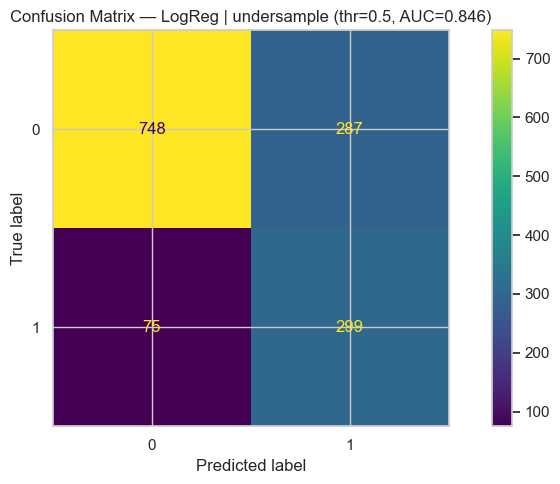


Classification report (thr=0.5):

              precision    recall  f1-score   support

           0      0.909     0.723     0.805      1035
           1      0.510     0.799     0.623       374

    accuracy                          0.743      1409
   macro avg      0.710     0.761     0.714      1409
weighted avg      0.803     0.743     0.757      1409



In [79]:
# --- Recover best model from results, rebuild pipeline, evaluate on test ---

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score

# where to save
fig_dir = (DIRS["figures"] if "DIRS" in globals() else "figures")
os.makedirs(fig_dir, exist_ok=True)

def load_results_df():
    # 1) if res_df already exists
    if "res_df" in globals():
        return res_df.copy()
    # 2) if there is "results" (list of dicts) from the loop
    if "results" in globals():
        df = pd.DataFrame(results)
        if not df.empty:
            return df.sort_values(["roc_auc","f1"], ascending=False).reset_index(drop=True)
    # 3) try files
    candidates = [
        "reports/model_results.csv",
        os.path.join("churn-capstone","reports","model_results.csv"),
        "/home/sandbox/reports/model_results.csv",
        "/mnt/data/churn-capstone/reports/model_results.csv",
    ]
    for p in candidates:
        if os.path.exists(p):
            df = pd.read_csv(p)
            return df.sort_values(["roc_auc","f1"], ascending=False).reset_index(drop=True)
    raise RuntimeError("Не найдено res_df/results и файл reports/model_results.csv — запусти блок с экспериментами.")

# 1) load results and pick the best row
res_df_local = load_results_df()
best_row = res_df_local.iloc[0]
best_label = f"{best_row['model']} | {best_row['imbalance']}"
print("Best combination:", best_label)

# 2) rebuild the pipeline
best_strat = best_row["imbalance"]
best_model_name = best_row["model"]
best_sampler = imbalance_strategies.get(best_strat)  # None for none/class_weight
best_cw = "balanced" if best_strat == "class_weight" else None
best_model = get_models(class_weight=best_cw)[best_model_name]

steps = [("pre", preprocess)]
if best_sampler is not None:
    steps.append(("sampler", best_sampler))
steps.append(("clf", best_model))
best_pipe = ImbPipeline(steps).fit(X_train, y_train)

# 3) evaluate on the test set
if hasattr(best_pipe, "predict_proba"):
    p = best_pipe.predict_proba(X_test)[:, 1]
else:
    s = best_pipe.decision_function(X_test)
    p = (s - s.min()) / (s.max() - s.min() + 1e-9)

y_hat = (p >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_hat)
auc = roc_auc_score(y_test, p)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format="d")
plt.title(f"Confusion Matrix — {best_label} (thr=0.5, AUC={auc:.3f})")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "confusion_matrix_best.png"), dpi=150)
plt.show()

print("\nClassification report (thr=0.5):\n")
print(classification_report(y_test, y_hat, digits=3))
